In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [3]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
tf.test.is_built_with_cuda()

True

In [5]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 16011 files belonging to 10 classes.


In [6]:
class_names=dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [7]:
len(dataset)

501

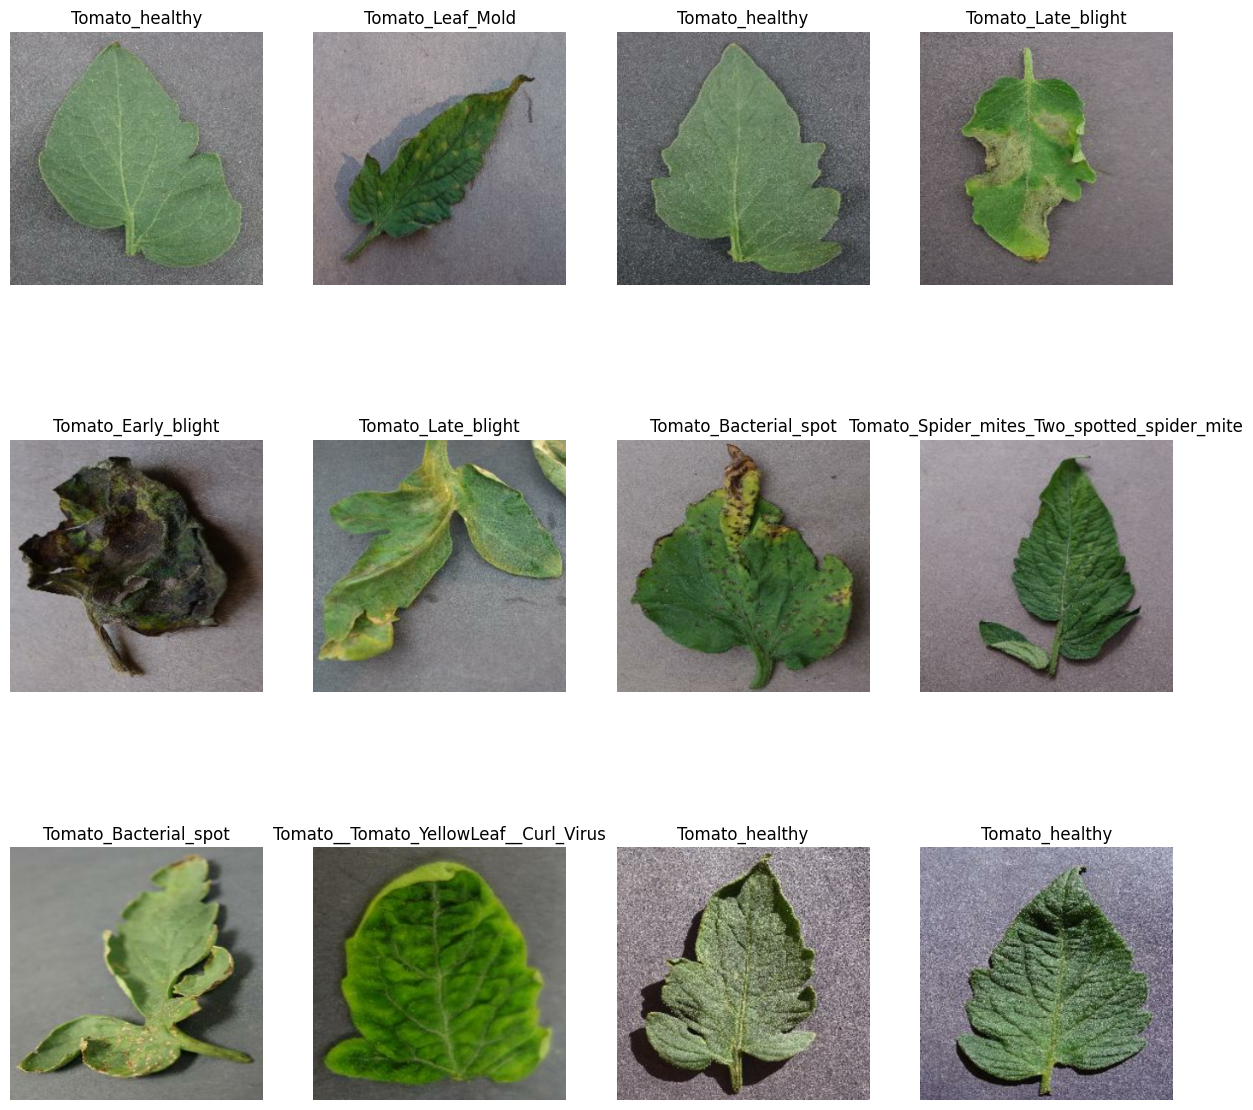

In [8]:
plt.figure(figsize=(15,15))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [9]:
train_size=0.8 # 80% for training
len(dataset)*train_size

400.8

In [10]:
train_ds=dataset.take(400)
len(train_ds)

400

In [11]:
sep_ds=dataset.skip(400) #separating dataset for validation and testing
len(sep_ds)

101

In [12]:
val_size=0.1 #10% for testing and validation
len(dataset)*val_size

50.1

In [13]:
val_ds=sep_ds.take(50)
len(val_ds)

50

In [14]:
test_ds=sep_ds.skip(50)
len(test_ds)

51

In [15]:
# generalizing above calculation
def get_dataset_partition_tf(ds, train_split=0.8, test_split=0.1, val_split=0.1, shuffle=True, shuffle_size=10000 ):
    ds_size=len(ds)

    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12) #seed is for predictability
    
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)

    return train_ds, test_ds, val_ds

In [16]:
train_ds, test_ds, val_ds=get_dataset_partition_tf(dataset)

In [17]:
len(train_ds)

400

In [18]:
len(val_ds)

50

In [19]:
len(test_ds)

51

In [20]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
#preprocessing
resize_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),           #used in case during prediction of image, size is not 256x256(like in the dataset)
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [22]:
#data augmentation
data_aug=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [23]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=10

model = models.Sequential([
    resize_rescale,
    data_aug,

    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 299, 299, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 299, 299, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 297, 297, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 148, 148, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                  

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
with tf.device('/GPU:0'):
    history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
    )

Epoch 1/50
400/400 [==============================] - 246s 341ms/step - loss: 1.2867 - accuracy: 0.5648 - val_loss: 1.3876 - val_accuracy: 0.5556
Epoch 2/50
400/400 [==============================] - 100s 250ms/step - loss: 0.6424 - accuracy: 0.7747 - val_loss: 1.5487 - val_accuracy: 0.5675
Epoch 3/50
400/400 [==============================] - 80s 200ms/step - loss: 0.4812 - accuracy: 0.8336 - val_loss: 0.7723 - val_accuracy: 0.7456
Epoch 4/50
400/400 [==============================] - 82s 205ms/step - loss: 0.3999 - accuracy: 0.8605 - val_loss: 0.7906 - val_accuracy: 0.7437
Epoch 5/50
400/400 [==============================] - 83s 206ms/step - loss: 0.3426 - accuracy: 0.8834 - val_loss: 0.7460 - val_accuracy: 0.7613
Epoch 6/50
400/400 [==============================] - 81s 201ms/step - loss: 0.2895 - accuracy: 0.8983 - val_loss: 0.7183 - val_accuracy: 0.7894
Epoch 7/50
400/400 [==============================] - 84s 210ms/step - loss: 0.2708 - accuracy: 0.9070 - val_loss: 0.5574 - val_

In [27]:
scores=model.evaluate(test_ds)

51/51 [==============================] - 70s 65ms/step - loss: 0.6879 - accuracy: 0.8879


In [28]:
history

In [29]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 400}

In [30]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

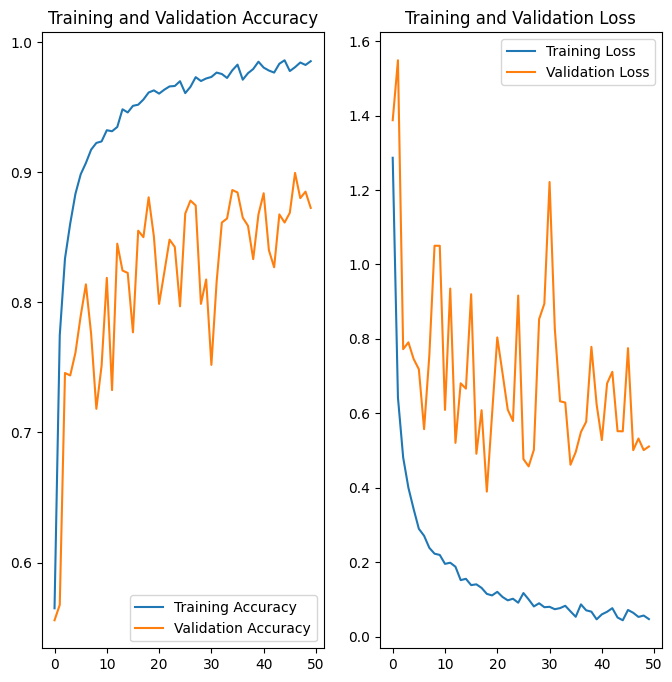

In [31]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

first image to predict
actual label:  Tomato__Tomato_YellowLeaf__Curl_Virus
1/1 [==============================] - 1s 502ms/step
predicted label: Tomato__Tomato_YellowLeaf__Curl_Virus


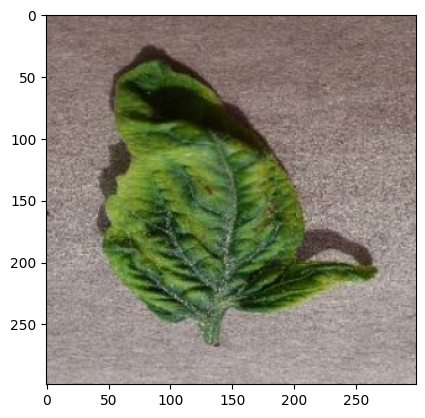

In [32]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype('uint8')
    first_label=labels_batch[0]

print("first image to predict")
plt.imshow(first_image)
print("actual label: ",class_names[first_label])

batch_prediction=model.predict(images_batch)
print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [33]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0) #create a batch

    predictions=model.predict(img_array)

    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 15ms/step


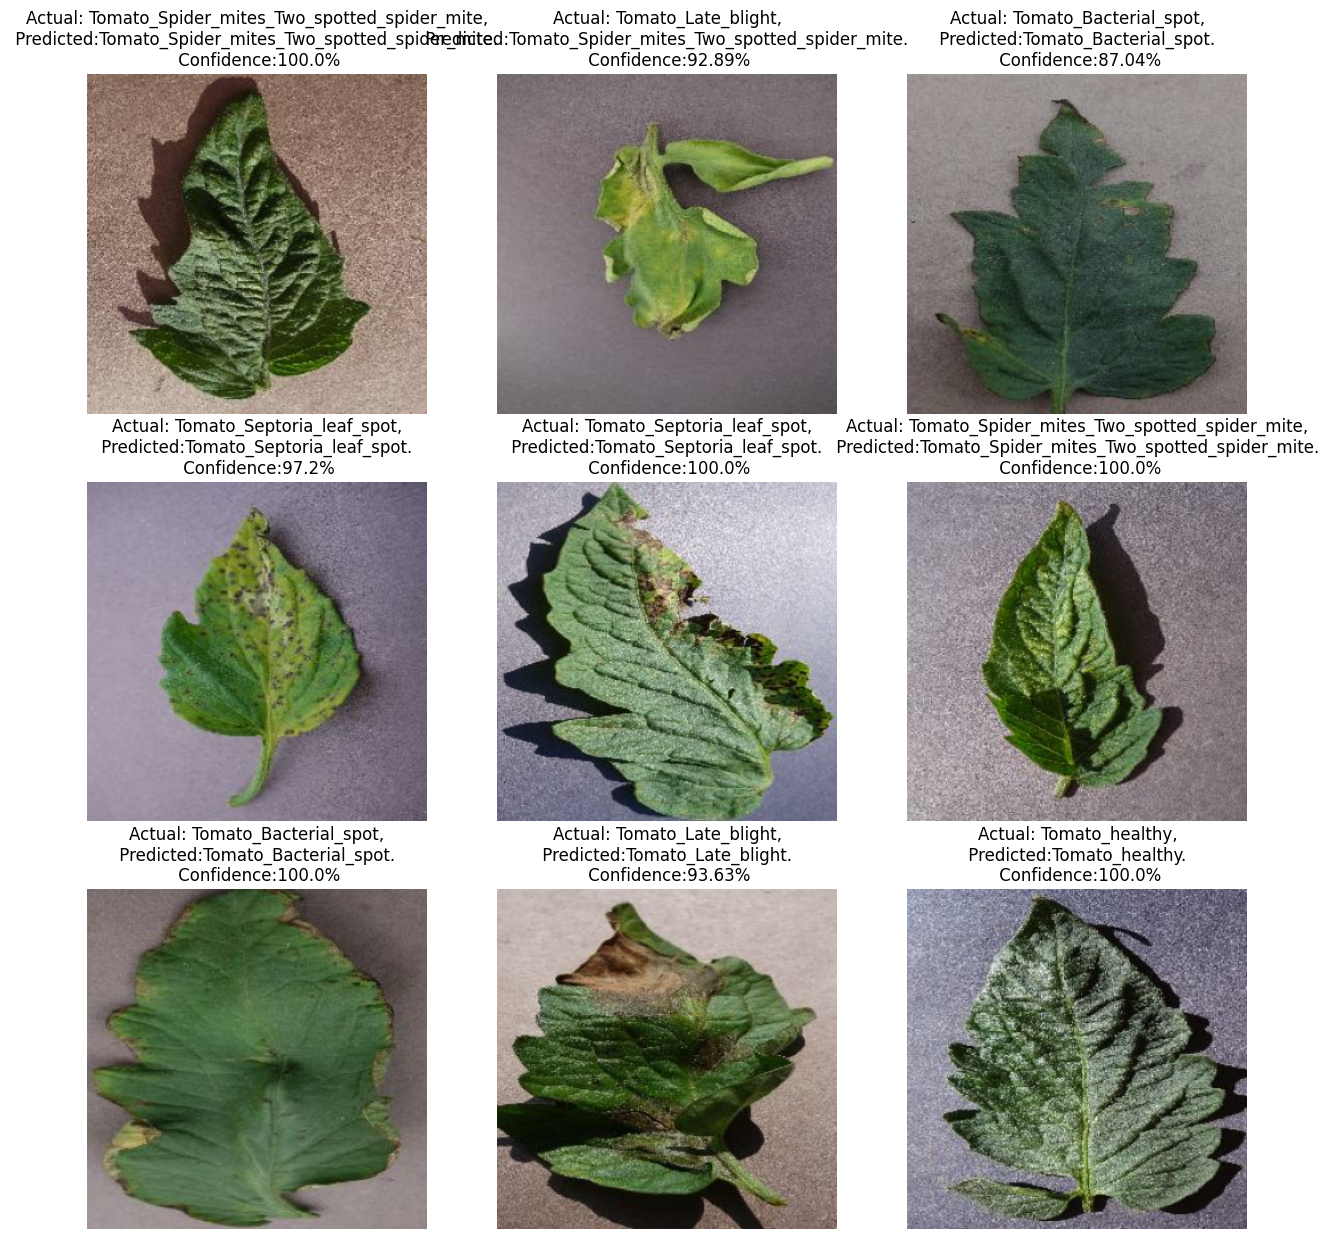

In [34]:
plt.figure(figsize=(15,15))
for images, labels in  test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted:{predicted_class}. \n Confidence:{confidence}%")
        plt.axis("off")

In [35]:
model_version=7
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
